In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'predict-energy-behavior-of-prosumers'

! mkdir data

! unzip /content/predict-energy-behavior-of-prosumers.zip -d data

Saving kaggle.json to kaggle.json
100% 232M/233M [00:10<00:00, 25.2MB/s]
100% 233M/233M [00:10<00:00, 23.6MB/s]
Archive:  /content/predict-energy-behavior-of-prosumers.zip
  inflating: data/client.csv         
  inflating: data/county_id_to_name_map.json  
  inflating: data/electricity_prices.csv  
  inflating: data/enefit/__init__.py  
  inflating: data/enefit/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: data/example_test_files/client.csv  
  inflating: data/example_test_files/electricity_prices.csv  
  inflating: data/example_test_files/forecast_weather.csv  
  inflating: data/example_test_files/gas_prices.csv  
  inflating: data/example_test_files/historical_weather.csv  
  inflating: data/example_test_files/revealed_targets.csv  
  inflating: data/example_test_files/sample_submission.csv  
  inflating: data/example_test_files/test.csv  
  inflating: data/forecast_weather.csv  
  inflating: data/gas_prices.csv     
  inflating: data/historical_weather.csv  
  inflating

In [ ]:
!pip install git+https://github.com/Nixtla/neuralforecast@main # Need to install from git, because latest release does not have callbacks which we want to use in optimization

  Cloning https://github.com/Nixtla/neuralforecast (to revision main) to /tmp/pip-req-build-oabzypgf
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast /tmp/pip-req-build-oabzypgf
  Resolved https://github.com/Nixtla/neuralforecast to commit 8a05d89852906b30eac7cf1bba15deda9e5618c2
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31

In [ ]:
!pip install --q -U polars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 52.5 MB/s eta 0:00:00


In [ ]:
!pip install --U numpy==1.24.4


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --U


In [ ]:
!pip install -U pytorch-lightning==2.0.0 optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.1.3
    Uninstalling pytorch-lightning-2.1.3:
      Successfully uninstalled pytorch-lightning-2.1.3


In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import holidays
import datetime
import warnings
import os
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast

# Data preparation

Follows: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [ ]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )

    df_consume = (
        df_data
        .filter(pl.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(pl.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .drop("is_consumption")
    )

    df_client = (
        df_client
        .with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date))
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((pl.col("date") + pl.duration(days=1)).cast(pl.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=pl.col("datetime") + pl.duration(days=1))
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(pl.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        .drop("date")
    )

    return df_data

In [ ]:
def clean_interpolate_timeseries(df_data):

    # don't want this segment, most of the data is missing
    df_data = df_data.loc[
        ~(df_data[["county", "is_business", "product_type"]] == (12, 1, 3)).all(axis=1)
    ]

    chunks = []
    for (county, is_business, product_type), grp in df_data.groupby(
            ["county", "is_business", "product_type"]
    ):
        # interpolate missing values
        interpolated = (
            grp.sort_values(by="datetime")
            .set_index("datetime")
            .interpolate(method="time")
            .reset_index()
        )

        has_gaps = len(interpolated["datetime"].diff().value_counts()) != 1
        if has_gaps:
            # it is assumed that there will be no gaps between observations
            warnings.warn(
                f"{(is_business,product_type,county)=} has gaps in data (there are larger gaps than 1h in datetime column); skipping this series."
            )
            continue
        chunks.append(interpolated)
    df_train_interpolated = pd.concat(chunks).reset_index()

    return df_train_interpolated

In [ ]:
class FeaturesGenerator:
    def __init__(self):
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns( # for absolute positional embeddings:
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features


    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "hour", "dayofyear"
        )
        return df_features

    def generate_features(self, df_features):

        for add_features in [
            self._add_general_features,
            self._add_holidays_features,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        return df_features

In [ ]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")

    return df

In [ ]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"
root = "data"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [ ]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(pl.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(pl.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(pl.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [ ]:
feat_gen = FeaturesGenerator()

In [ ]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = feat_gen.generate_features(df_train)
df_train = clean_interpolate_timeseries(to_pandas(df_train))

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [ ]:
# Remove old data
df_train = df_train[df_train["datetime"] >= pd.to_datetime("2022-11-03 00:00:00")]
df_train = df_train[df_train["datetime"] <= pd.to_datetime("2023-05-24 23:00:00")]

In [ ]:
df_train.shape

(302064, 34)

In [ ]:
df_train.columns

Index(['index', 'datetime', 'county', 'is_business', 'product_type',
       'production', 'consumption', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'eic_count', 'installed_capacity',
       'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'day', 'weekday', 'month', 'year',
       'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)',
       'is_country_holiday'],
      dtype='object')

In [ ]:
df_train.isna().sum()

index                                0
datetime                             0
county                               0
is_business                          0
product_type                         0
production                           0
consumption                          0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
eic_count                            0
installed_capacity                   0
euros_per_mwh                        0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
day                                  0
weekday                  

In [ ]:
static_df = df_train[["segment", "county", "is_business", "product_type"]]
static_df = static_df.drop_duplicates().rename(columns={'segment':'unique_id'})

# 2. Forecasting PRODUCTION

Follows: https://nixtlaverse.nixtla.io/neuralforecast/examples/longhorizon_with_transformers.html

In [ ]:
import optuna
from neuralforecast.losses.pytorch import MAE

In [ ]:
from neuralforecast.models import VanillaTransformer

In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

# Because optuna does not support the latest lightning version...
# https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [ ]:
from neuralforecast.utils import HourOfDay, DayOfWeek, DayOfMonth, DayOfYear

# "dayhour","weekday", "monthday", "yearday"
hd = HourOfDay()
dw = DayOfWeek()
dm = DayOfMonth()
dy = DayOfYear()

df_train['dayhour'] = df_train['datetime'].apply(lambda x: hd(x))
df_train['weekday'] = df_train['datetime'].apply(lambda x: dw(x))
df_train['monthday'] = df_train['datetime'].apply(lambda x: dm(x))
df_train['yearday'] = df_train['datetime'].apply(lambda x: dy(x))

# We use these in range [-0.5,0.5] as absolute positional embeddings
df_train[["dayhour","weekday", "monthday", "yearday"]]

,dayhour,weekday,monthday,yearday
10272,-0.500000,0.000000,-0.433333,0.338356
10273,-0.456522,0.000000,-0.433333,0.338356
10274,-0.413043,0.000000,-0.433333,0.338356
10275,-0.369565,0.000000,-0.433333,0.338356
10276,-0.326087,0.000000,-0.433333,0.338356
...,...,...,...,...
929443,0.326087,-0.166667,0.266667,-0.108219
929444,0.369565,-0.166667,0.266667,-0.108219
929445,0.413043,-0.166667,0.266667,-0.108219
929446,0.456522,-0.166667,0.266667,-0.108219


In [ ]:
# TRAIN-TEST split

start_date = pd.to_datetime("2022-11-03 00:00:00")
end_date = pd.to_datetime("2023-05-24 23:00:00")
datetime_range = pd.date_range(start=start_date, end=end_date, freq='H')

test_cutoff = pd.to_datetime("2023-05-15 09:00:00") # This will give leave about 0.95 to train and 0.05 to test. Done to match neuralforecast internal split

train_datetime_range = datetime_range[datetime_range < test_cutoff]
test_datetime_range = datetime_range[datetime_range >= test_cutoff]

train = df_train[df_train['datetime'].isin(train_datetime_range)]
test = df_train[df_train['datetime'].isin(test_datetime_range)]

In [ ]:
len(train) / len(df_train)

0.9525862068965517

In [ ]:
len(test) / len(df_train)

0.04741379310344827

In [ ]:
import torch
import gc
from neuralforecast.losses.numpy import mae

In [ ]:
static = ["county", "is_business", "product_type"]
past_covariates = ["consumption","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards",
                    "is_country_holiday"]
calendar_cols = ["dayhour", "weekday", "monthday", "yearday"]

In [ ]:
def objective(trial):

    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    torch.cuda.empty_cache()
    gc.collect()

    output_size = 2*24 # predicting 2 days ahead
    input_size = trial.suggest_int('input_size', 3*24, 14*24)

    hidden_size = trial.suggest_categorical("hidden_size", [16, 64, 128, 256])
    n_heads = trial.suggest_categorical("n_head", [1, 4, 8, 16])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1) # 1e-4 to 1e-1 by default
    scaler_type = trial.suggest_categorical("scaler_type", [None, "robust", "standard"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    windows_batch_size = trial.suggest_categorical("windows_batch_size", [64, 128, 256, 512])
    drop_out_rate = trial.suggest_categorical("drop_out_rate",[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]) # Default is 0.2

    models =  [VanillaTransformer(h=output_size,
                   input_size=input_size,
                   futr_exog_list=calendar_cols, # Used for absolute positional embeddings
                   hidden_size=hidden_size,
                   n_head=n_heads,
                   dropout=drop_out_rate,
                   loss=MAE(),
                   valid_loss=None,
                   max_steps=1000, # 1000 is the default
                   learning_rate=learning_rate,
                   val_check_steps=50, # 100 is the default
                   early_stop_patience_steps=3,
                   batch_size=batch_size,
                   windows_batch_size=windows_batch_size,
                   scaler_type=scaler_type,
                   random_seed=1)]

    n_time = len(train['datetime'].unique())
    val_size = int(.05 * n_time)
    test_size = int(.05 * n_time)

    nf = NeuralForecast(
          models=models,
          freq='H')

    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                                  val_size=val_size,
                                  test_size=test_size,
                                  n_windows=None)

    loss = mae(Y_hat_df['y'], Y_hat_df['VanillaTransformer'])

    return loss if loss != np.nan else float("inf")

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
pruner = optuna.pruners.MedianPruner()

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, callbacks=[print_callback], pruner=pruner)

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-24 09:22:48,232] A new study created in memory with name: no-name-dc859877-1e5c-4f37-b76c-e5d841bddf82
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:25:05,179] Trial 0 finished with value: 402.7702331542969 and parameters: {'input_size': 270, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 3.549074930769434e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.3}. Best is trial 0 with value: 402.7702331542969.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 402.7702331542969, Current params: {'input_size': 270, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 3.549074930769434e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.3}
Best value: 402.7702331542969, Best params: {'input_size': 270, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 3.549074930769434e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:25:44,627] Trial 1 finished with value: 403.86993408203125 and parameters: {'input_size': 283, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.00014314004404240637, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.9}. Best is trial 0 with value: 402.7702331542969.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 403.86993408203125, Current params: {'input_size': 283, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.00014314004404240637, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.9}
Best value: 402.7702331542969, Best params: {'input_size': 270, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 3.549074930769434e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:25:59,305] Trial 2 finished with value: 413.14227294921875 and parameters: {'input_size': 210, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.0003321983130807817, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 64, 'drop_out_rate': 0.4}. Best is trial 0 with value: 402.7702331542969.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 413.14227294921875, Current params: {'input_size': 210, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.0003321983130807817, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 64, 'drop_out_rate': 0.4}
Best value: 402.7702331542969, Best params: {'input_size': 270, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 3.549074930769434e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:26:50,921] Trial 3 finished with value: 389.6571044921875 and parameters: {'input_size': 262, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.024951415182139287, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.2}. Best is trial 3 with value: 389.6571044921875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 389.6571044921875, Current params: {'input_size': 262, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.024951415182139287, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.2}
Best value: 389.6571044921875, Best params: {'input_size': 262, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.024951415182139287, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:27:13,451] Trial 4 finished with value: 392.2871398925781 and parameters: {'input_size': 175, 'hidden_size': 128, 'n_head': 16, 'learning_rate': 0.00745628156129927, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 64, 'drop_out_rate': 0.7}. Best is trial 3 with value: 389.6571044921875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 392.2871398925781, Current params: {'input_size': 175, 'hidden_size': 128, 'n_head': 16, 'learning_rate': 0.00745628156129927, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 64, 'drop_out_rate': 0.7}
Best value: 389.6571044921875, Best params: {'input_size': 262, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.024951415182139287, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:28:12,822] Trial 5 finished with value: 389.7921142578125 and parameters: {'input_size': 289, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.006181912935101745, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.5}. Best is trial 3 with value: 389.6571044921875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 389.7921142578125, Current params: {'input_size': 289, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.006181912935101745, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.5}
Best value: 389.6571044921875, Best params: {'input_size': 262, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.024951415182139287, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:28:46,276] Trial 6 finished with value: 403.4239501953125 and parameters: {'input_size': 189, 'hidden_size': 16, 'n_head': 1, 'learning_rate': 0.06615777261389769, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.9}. Best is trial 3 with value: 389.6571044921875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 403.4239501953125, Current params: {'input_size': 189, 'hidden_size': 16, 'n_head': 1, 'learning_rate': 0.06615777261389769, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.9}
Best value: 389.6571044921875, Best params: {'input_size': 262, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.024951415182139287, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:30:25,946] Trial 7 finished with value: 389.2751159667969 and parameters: {'input_size': 335, 'hidden_size': 16, 'n_head': 1, 'learning_rate': 3.165009298292543e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}. Best is trial 7 with value: 389.2751159667969.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 389.2751159667969, Current params: {'input_size': 335, 'hidden_size': 16, 'n_head': 1, 'learning_rate': 3.165009298292543e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}
Best value: 389.2751159667969, Best params: {'input_size': 335, 'hidden_size': 16, 'n_head': 1, 'learning_rate': 3.165009298292543e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:31:54,341] Trial 8 finished with value: 399.3729553222656 and parameters: {'input_size': 270, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.007455559149747984, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.7}. Best is trial 7 with value: 389.2751159667969.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 399.3729553222656, Current params: {'input_size': 270, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.007455559149747984, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.7}
Best value: 389.2751159667969, Best params: {'input_size': 335, 'hidden_size': 16, 'n_head': 1, 'learning_rate': 3.165009298292543e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:32:33,390] Trial 9 finished with value: 400.0495910644531 and parameters: {'input_size': 110, 'hidden_size': 64, 'n_head': 16, 'learning_rate': 0.0037693704148614574, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64, 'drop_out_rate': 0.3}. Best is trial 7 with value: 389.2751159667969.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 400.0495910644531, Current params: {'input_size': 110, 'hidden_size': 64, 'n_head': 16, 'learning_rate': 0.0037693704148614574, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64, 'drop_out_rate': 0.3}
Best value: 389.2751159667969, Best params: {'input_size': 335, 'hidden_size': 16, 'n_head': 1, 'learning_rate': 3.165009298292543e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:35:17,465] Trial 10 finished with value: 386.58172607421875 and parameters: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.5143806477601706e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}. Best is trial 10 with value: 386.58172607421875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 386.58172607421875, Current params: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.5143806477601706e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}
Best value: 386.58172607421875, Best params: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.5143806477601706e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:35:54,832] Trial 11 finished with value: 387.1895751953125 and parameters: {'input_size': 329, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.0039982989843096e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}. Best is trial 10 with value: 386.58172607421875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 387.1895751953125, Current params: {'input_size': 329, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.0039982989843096e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}
Best value: 386.58172607421875, Best params: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.5143806477601706e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:36:36,845] Trial 12 finished with value: 386.92633056640625 and parameters: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.0775910381227141e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1}. Best is trial 10 with value: 386.58172607421875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 386.92633056640625, Current params: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.0775910381227141e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1}
Best value: 386.58172607421875, Best params: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.5143806477601706e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


Exception ignored in: <function _xla_gc_callback at 0x7d40f035dab0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:36:44,840] Trial 13 finished with value: 387.3890075683594 and parameters: {'input_size': 76, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.0285089936949817e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1}. Best is trial 10 with value: 386.58172607421875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 387.3890075683594, Current params: {'input_size': 76, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.0285089936949817e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1}
Best value: 386.58172607421875, Best params: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.5143806477601706e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-24 09:36:52,188] Trial 14 finished with value: 388.08831787109375 and parameters: {'input_size': 224, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 0.00010561812196254658, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1}. Best is trial 10 with value: 386.58172607421875.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 388.08831787109375, Current params: {'input_size': 224, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 0.00010561812196254658, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1}
Best value: 386.58172607421875, Best params: {'input_size': 334, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 1.5143806477601706e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.2}


[W 2024-01-24 09:36:53,343] Trial 15 failed with parameters: {'input_size': 308, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0010843726552281288, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-29-feae9d3f6375>", line 44, in objective
    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
  File "/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py", line 748, in cross_validation
    return self._no_refit_cross_validation(
  File "/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py", line 585, in _no_refit_cross_validation
    self.dataset, self.uids, self.last_dates, self.ds = self._prepare_fit(
  File "/usr/lo

KeyboardInterrupt: 

In [ ]:
study.best_trial.params

{'input_size': 334,
 'hidden_size': 256,
 'n_head': 1,
 'learning_rate': 1.5143806477601706e-05,
 'scaler_type': 'robust',
 'batch_size': 32,
 'windows_batch_size': 256,
 'drop_out_rate': 0.2}

In [ ]:
optuna.importance.get_param_importances(study)

{'scaler_type': 0.7960492349075992,
 'windows_batch_size': 0.0672368410961049,
 'drop_out_rate': 0.065867973365312,
 'n_head': 0.02684177921631528,
 'hidden_size': 0.020877581384189537,
 'input_size': 0.011679843877527227,
 'batch_size': 0.008267457533581136,
 'learning_rate': 0.0031792886193708907}

Default: VanillaTransformer (h:int, input_size:int, stat_exog_list=None,
                     hist_exog_list=None, futr_exog_list=None,
                     decoder_input_size_multiplier:float=0.5,
                     hidden_size:int=128, dropout:float=0.05,
                     n_head:int=4, conv_hidden_size:int=32,
                     activation:str='gelu', encoder_layers:int=2,
                     decoder_layers:int=1, loss=MAE(), valid_loss=None,
                     max_steps:int=5000, learning_rate:float=0.0001,
                     num_lr_decays:int=-1,
                     early_stop_patience_steps:int=-1,
                     val_check_steps:int=100, batch_size:int=32,
                     valid_batch_size:Optional[int]=None,
                     windows_batch_size=1024,
                     inference_windows_batch_size:int=1024,
                     start_padding_enabled=False, step_size:int=1,
                     scaler_type:str='identity', random_seed:int=1,
                     num_workers_loader:int=0,
                     drop_last_loader:bool=False, **trainer_kwargs)

Best params:
{'input_size': 111,
 'hidden_size': 64,
 'n_head': 4,
 'learning_rate': 0.0009786342894141167,
 'scaler_type': 'standard',
 'batch_size': 32,
 'windows_batch_size': 128,
 'drop_out_rate': 0.1,
 'random_seed': 18}

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
# Refit with optimal hyperparameters and use the test set with rolling predictions to calculate test MAE
models = [VanillaTransformer(h=2*24,
              input_size=111,
              hidden_size=64,
              n_head=4,
              loss=MAE(),
              batch_size=32,
              windows_batch_size=128,
              learning_rate=0.0009786342894141167,
              dropout=0.1,
              random_seed=7,
              futr_exog_list=calendar_cols, # Absolute positional embeddings are obtained from calendar features
              scaler_type='standard')]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))


INFO:lightning_fabric.utilities.seed:Global seed set to 7


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
from neuralforecast.losses.numpy import mae
mae_vanilla = mae(Y_hat_df['y'], Y_hat_df['VanillaTransformer'])
mae_vanilla

125.19898

In [ ]:
Y_hat_df = Y_hat_df.reset_index()

In [ ]:
Y_hat_df.to_csv('VanillaTransformer_prod_preds.csv')

In [ ]:
Y_hat_df.ds.unique().min().astype('datetime64[D]'), test.datetime.unique().min().astype('datetime64[D]')

In [ ]:
Y_hat_df.ds.unique().max().astype('datetime64[D]'), test.datetime.unique().max().astype('datetime64[D]')

Internally, neuralforecast does rolling prediction on the test set, using the lates available data in the lookback window.

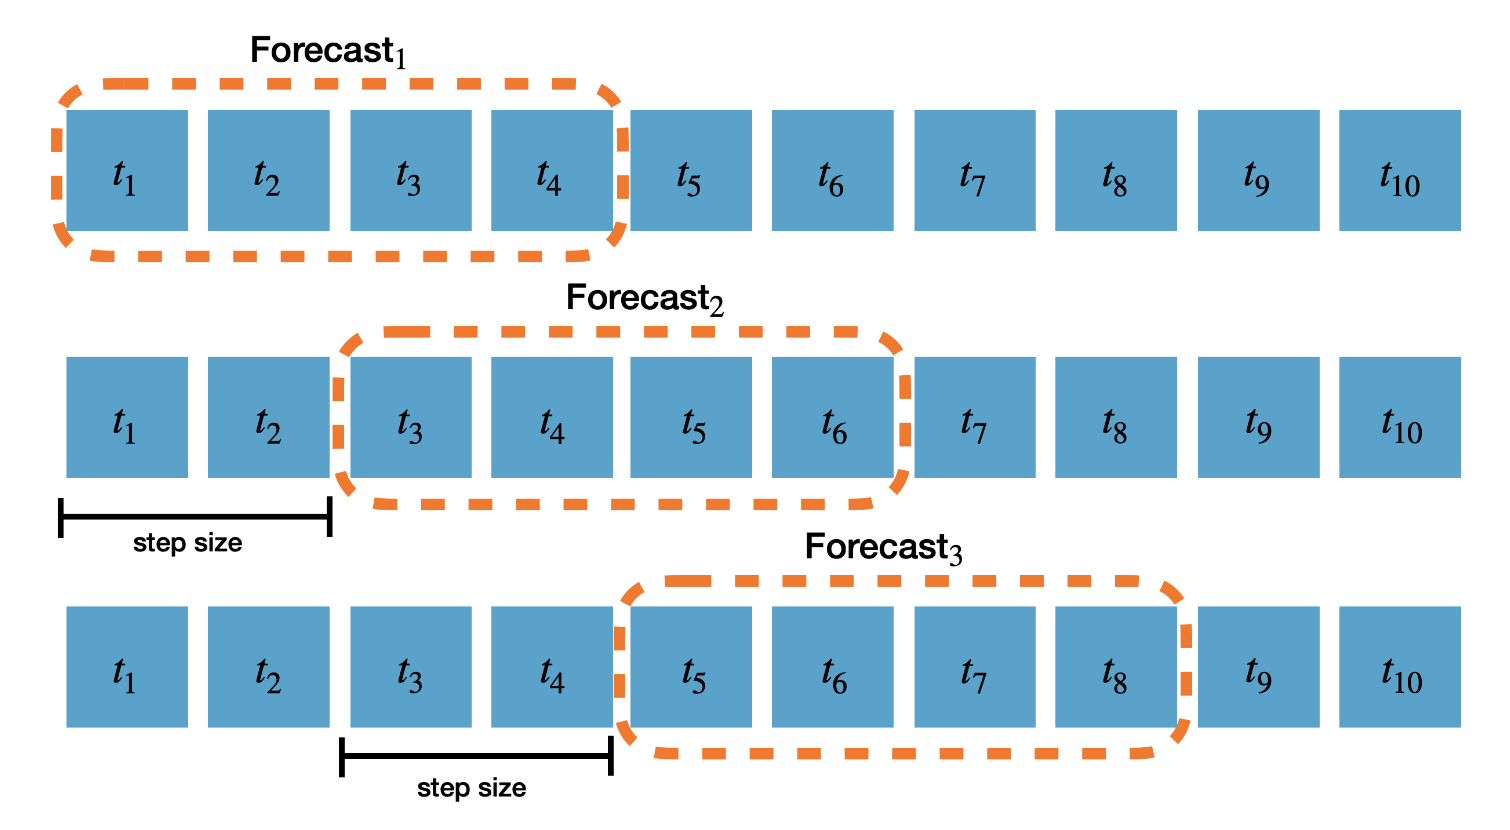

In [ ]:
# Visualize forecasts on one segment on one cutoff (the last window)
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::2*24]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Production prediction on test set (optimized VanillaTransformer)')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['VanillaTransformer'], label='VanillaTransformer')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('production_preds_optimized_VanillaTransformer.png')
plt.show()

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, nf.models[0].parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])

# Consumption

In [ ]:
import torch
import gc

In [ ]:
def objective(trial):

    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    torch.cuda.empty_cache()
    gc.collect()

    output_size = 2*24 # predicting 2 days ahead
    input_size = trial.suggest_int('input_size', 3*24, 14*24)

    hidden_size = trial.suggest_categorical("hidden_size", [16, 64, 128, 256])
    n_heads = trial.suggest_categorical("n_head", [1, 4, 8, 16])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1) # 1e-4 to 1e-1 by default
    scaler_type = trial.suggest_categorical("scaler_type", [None, "robust", "standard"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    windows_batch_size = trial.suggest_categorical("windows_batch_size", [64, 128, 256, 512])
    drop_out_rate = trial.suggest_categorical("drop_out_rate",[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]) # Default is 0.2

    models =  [VanillaTransformer(h=output_size,
                   input_size=input_size,
                   futr_exog_list=calendar_cols, # Used for absolute positional embeddings
                   hidden_size=hidden_size,
                   n_head=n_heads,
                   dropout=drop_out_rate,
                   loss=MAE(),
                   valid_loss=None,
                   max_steps=1000, # 1000 is the default
                   learning_rate=learning_rate,
                   val_check_steps=50, # 100 is the default
                   early_stop_patience_steps=3,
                   batch_size=batch_size,
                   windows_batch_size=windows_batch_size,
                   scaler_type=scaler_type,
                   random_seed=1)]

    n_time = len(train['datetime'].unique())
    val_size = int(.05 * n_time)
    test_size = int(.05 * n_time)

    nf = NeuralForecast(
          models=models,
          freq='H')

    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                                  val_size=val_size,
                                  test_size=test_size,
                                  n_windows=None,
                                  static_df=static_df.rename(columns={'segment':'unique_id'}))

    loss = mae(Y_hat_df['y'], Y_hat_df['VanillaTransformer'])

    return loss if loss != np.nan else float("inf")

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
study.best_trial.params

In [ ]:
# Refit with optimal hyperparameters and use the test set with rolling predictions to calculate test MAE
models = [VanillaTransformer(h=2*24,
              input_size=281,
              hidden_size=128,
              n_head=16,
              loss=MAE(),
              batch_size=16,
              windows_batch_size=512,
              learning_rate=0.0012249628919021166,
              dropout=0.3,
              random_seed=3,
              futr_exog_list=calendar_cols, # Absolute positional embeddings are obtained from calendar features
              scaler_type='robust',
              max_steps=1000,
              val_check_steps=100,
              early_stop_patience_steps=3)]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))

In [ ]:
from neuralforecast.losses.numpy import mae
mae_vanilla_c = mae(Y_hat_df['y'], Y_hat_df['VanillaTransformer'])
mae_vanilla_c

In [ ]:
(mae_vanilla + mae_vanilla_c) / 2

In [ ]:
Y_hat_df = Y_hat_df.reset_index()

In [ ]:
# Visualize forecasts on one segment on one cutoff (the last window)
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::2*24]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Consumption prediction on test set (optimized VanillaTransformer)')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['VanillaTransformer'], label='VanillaTransformer')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('consumption_preds_optimized_VanillaTransformer.png')
plt.show()